https://github.com/rolling-scopes-school/ml-intro/tree/2021/5_classification_linear_knn

In [ ]:
import sklearn
sklearn.__version__

# Classification. Linear models and KNN

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
# some imports for my accomplishments

# standard imports
import time
import random
import string

# interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import figure_factory as FF
# pd.options.plotting.backend = "plotly"

# progress bars
from tqdm import tqdm
tqdm.pandas()

# feature importance
import eli5
from eli5.sklearn import PermutationImportance
from yellowbrick.model_selection import FeatureImportances

In [ ]:
SEED = 42

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


seed_everything()

In [ ]:
def check_missing(df):
    df_miss_numerbers = df.isna().sum()
    df_miss_percents = data.isna().mean().round(4) * 100
    miss_df=pd.concat([df_miss_numerbers, df_miss_percents], axis=1)
    miss_df.rename(columns={0: 'numbers',  1: 'percent'}, inplace=True)
    miss_df = miss_df[miss_df.numbers > 0].sort_values(by=['percent'], ascending=False)
    display(miss_df.style.background_gradient())
    miss_df.plot.bar();
#     return miss_df

In [ ]:
def plot_corr_matr(c_matr):
    f, ax = plt.subplots(figsize=(16, 14))
    matrix_tr = np.triu(c_matr)

    sns.heatmap(
        c_matr, 
        mask=matrix_tr, 
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        linewidths=0.5,
        square=True, 
        ax=ax,
        annot=True
    );

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
# PATH = "./data/"
PATH = "../input/"

In [ ]:
# insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insurance_data = pd.read_csv(os.path.join(PATH, 'porto-seguro-safe-driver-prediction', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

The relationship between the area under the ROC curve (AUC) and the Gini is
noted in several papers. However, the terminology is not always clear, and sometimes
it is not consistent with the definitions used in the economic literature. For example,
(1999) states: “Note that our usage of the Lorenz curve is actually different from that
of economists or demographers. However, we still call it the Lorenz curve... We can
also define the Gini index as twice the area between the Lorenz curve itself and the
diagonal line”. Lee’s (Lee, 1997; Lee, 1999) interpretation of the Lorenz curve was
also used by others. For example, Lilja et al.(2011) quotes Lee (1999) and says: “A
Lorenz curve plots centiles of the risk factor, in this case PSA, against the cumulative
proportion of cases”. Liu, White and Newell (2011) write: “The AUC is also closely
related to the Gini coefficient..... which is twice the area between the diagonal and
the ROC curve”. Siadaty et al.(2004) mention that: “Lee (1999) believes that, using
a Lorenz curve, Pietra and Gini indexes have a closer tie with real world medical
diagnosis......Correspondence between the suggested method and recent measures of
performance like area swept out by the curve, projected length of the curve, or the Lorenz curve indexes Pietra and Gini may be worth investigating”. Recently Irwin
and Hautus (2015) treated a special case. They showed that the lognormal model
of the Lorenz curve, which is often adopted to model the distribution of income and
wealth, is a mirror image of the equal-variance normal model of the ROC curve.
They mention that in general ROC curves do not have corresponding rotated Lorenz
curves, a fact that was mentioned by Lee (1999) as well.

More commonly, the classification and diagnosis literature that relates the Gini
terminology to AUC ignores the difference mentioned in Lee (1999) and wrongly
states Gini = 2AUC − 1, where the variable for which Gini is computed is not
specified. This statement appears in other areas as well. For example, in the Machine
Learning literature Hand and Till (2001) write: “The AUC measure of performance
is closely related to the Gini coefficient, which is sometimes used as an alternative
measure. This is most commonly defined as twice the area between the ROC curve
and the diagonal.... Elementary geometry shows that Gini + 1 = 2AUC”. The same
statement is mentioned by Gajowniczek, Zabkowski and Szupiluk (2014) who write:”
Since the ROC curve measures the inequality between the good and the bad score
distributions, it seems reasonable to show a relation between the ROC curve and
the Lorenz curve. Twice the area between the Lorenz curve and the diagonal line at
45 degree corresponds to the Gini concentration index. This leads to an interesting
interpretation of the AUC measure in terms of the Gini coefficient: Gini = 2AUC
-1”.

We note however that under the additional assumption that the prediction model
is well calibrated and unbiased, Wu and Lee (2014) show that the relationship Gini =
2AUC − 1 (where Gini is the Gini of the predictive probabilities) holds true.

The objectives of this note are to correct a common error and to clarify the
connection between the Gini terminology as used in the economic literature and
the one used in the diagnostic and classification literature. The main point is that
the standard Gini (sometimes called Gini mean difference (GMD)) is a variability
measure of one particular variable, while the AUC involves two variables. It turns
out that the economic literature has a term, called Gini covariance, which is similar
but not quite the same as Gini. In particular, it is a bivariate parameter (while
Gini is a univariate parameter that relates X to its cumulative distribution function
FX(X); see Section 2 below), which fits the usage of the diagnostic and classification
community perfectly. We show that the ROC curve can be presented as a relative
concentration curve for a properly defined X and Y , hence the area between the ROC
curve and the 45-degree line can be calculated as a Gini covariance up to constants.

Gini index is the common measure of inequality: higher value of Gini index indicates
higher inequality. We start with the definition of the Gini (usually called Gini mean
difference, GMD). The original definition of Gini (by Gini in 1914) is G(X) = E|X1−
X2| where X1 and X2 are independent and identically distributed copies of X. There
are more than a dozen equivalent ways to present Gini (see Yitzhaki, 1998). The
way which is most relevant to this note is G(X) = 4Cov(X, FX(X)), where FX is the
cumulative distribution function of X (see Lerman and Yitzhaki, 1984). A natural
extension of the Gini to a bivariate data (which is more relevant to this note) is the
Gini-covariance, which is defined for a bivariate variable (X, Y ) as Cov(X, FY (Y )) where FY is the cumulative distribution of Y . Gini covariance is the basic building
block in Gini correlation, which is applied when one variable is given in its variate
values while the other is ranked (see Schechtman and Yitzhaki, 1987). Note that
while Gini is a one dimensional parameter, Gini–covariance (also called co–Gini) is a
two-dimensional parameter. Gini index, which is relevant to our paper, is the GMD
divided by twice the mean.

Next, we present the Lorenz curve and the concentration curve for the continuous
case (see Yitzhaki and Schechtman, 2013). The Lorenz curve plots the cumulative
proportion of a variable against the cumulative proportion of the population ranked
by it. A typical Lorenz curve will have a convex shape connecting the points (0, 0)
with (1, 1). In the example above, the height of the curve above the point 1/4 is the
share of the income of the poorest 25% of the population. The Gini is equal to twice
the area bounded between this curve and the diagonal.

Lee (1997) discusses several interpretations of the geometrically defined Gini index. We note in passing that the definition used by him for the Lorenz curve is
somewhat different from the one used by economists (Lee, 1997; Lee, 1999). One
such interpretation is the coefficient of deviation in disease risk. This coefficient is
similar to the coefficient of variation, where the standard deviation is replaced by
Gini mean difference.

The concentration curve is the bivariate analogue of the Lorenz curve. It plots
the cumulative proportion of one variable against the cumulative proportion of the
population ranked by another variable.

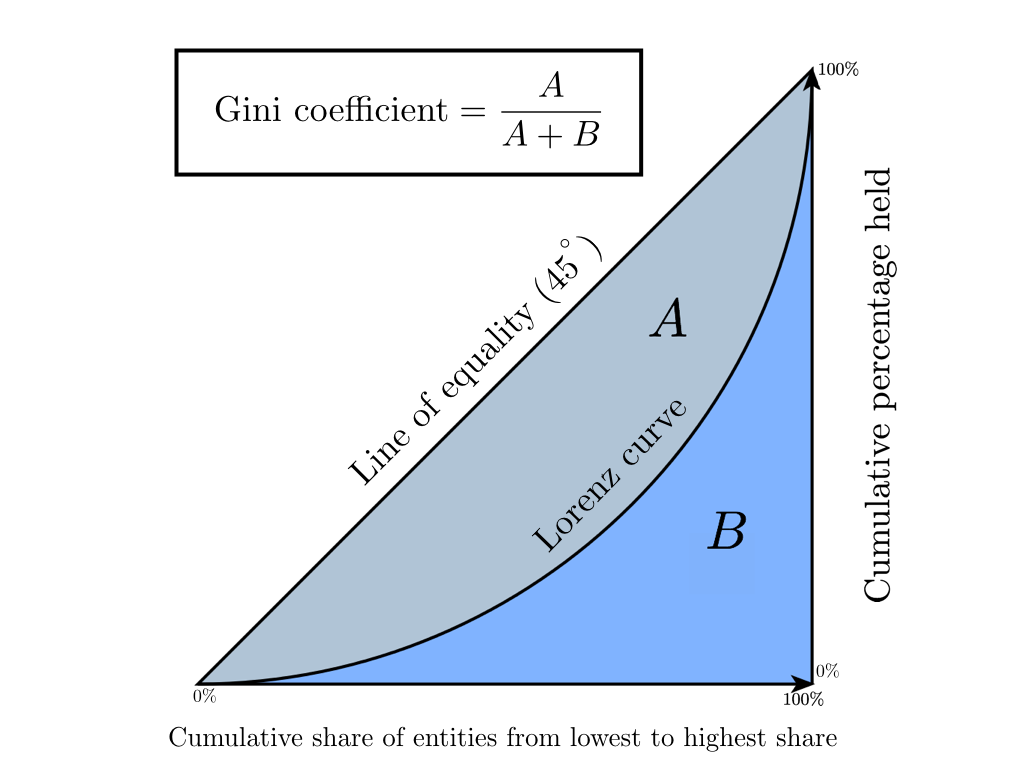

In [ ]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predict = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]
data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

aucroc = roc_auc_score(actual, predict)
gini = 2*roc_auc_score(actual, predict) - 1
fpr, tpr, t = roc_curve(actual, predict)

fig, ax = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(15, 5))
fig.suptitle('Gini = 2 * AUCROC - 1 = {:0.2f}\n\n'.format(gini),fontsize = 18, fontweight='bold')
ax[0].plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
ax[0].fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.2f}'.format(aucroc),fontsize = 28)
ax[1].plot(x_values, y_values, lw = 2, color = 'blue')
ax[1].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.2f}'.format(S_pred),fontsize = 28)
ax[2].plot(x_values, y_values_perfect, lw = 2, color = 'green')
ax[2].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[2].text(0.4,0.2,'S = {:0.2f}'.format(S_actual),fontsize = 28)
ax[0].set(title='ROC-AUC', xlabel='False Positive Rate', 
              ylabel='True Positive Rate', xlim=(0, 1), ylim=(0, 1))

for i in range(1,3):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.interpolate import interp1d
from scipy.integrate import quad

df = insurance_data.copy()
unwanted = df.columns[df.columns.str.startswith('ps_calc_')]
df.drop(unwanted,inplace=True,axis=1)
df.fillna(-999, inplace=True)

train, test = train_test_split(df, stratify=df.target, test_size=0.25, random_state=1)
estimator = xgb.XGBClassifier(seed=1, n_jobs=-1)
estimator.fit(train.drop('target', axis=1), train.target)
pred = estimator.predict_proba(test.drop('target', axis=1))[:, 1]
test['predict'] = pred

actual = test.target.values
predict = test.predict.values

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

aucroc = roc_auc_score(actual, predict)
gini = 2*roc_auc_score(actual, predict)-1
fpr, tpr, t = roc_curve(actual, predict)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

fig, ax = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(18, 6))
fig.suptitle('Gini = {:0.3f}\n\n'.format(gini),fontsize = 26, fontweight='bold')
ax[0].plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw=2, color = 'red')
ax[0].plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
ax[0].fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.3f}'.format(aucroc),fontsize = 28)
ax[1].plot(x_values, y_values, lw = 2, color = 'blue')
ax[1].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.3f}'.format(S_pred),fontsize = 28)
ax[2].plot(x_values, y_values_perfect, lw = 2, color = 'green')
ax[2].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[2].text(0.4,0.2,'S = {:0.3f}'.format(S_actual),fontsize = 28)
ax[0].set(title='ROC-AUC XGBoost Baseline', xlabel='False Positive Rate', 
              ylabel='True Positive Rate', xlim=(0, 1), ylim=(0, 1))
ax[1].set(title='Gini XGBoost Baseline')
ax[2].set(title='Gini Perfect')

for i in range(1,3):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(xlabel='Share of clients', ylabel='True Positive Rate', xlim=(0, 1), ylim=(0, 1))
plt.show();

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

* F1 metric is the harmonic average of the precision and recall and calculated as

$
F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}
$

this metric is a good choice for the imbalanced classification scenario. The range of F1 is in [0, 1], where 1 is perfect classification and 0 is total failure.

* MCC (Matthews Correlation Coefficient)
mcc is extremely good metric for the imbalanced classification and can be safely used even classes are very different in sizes

$
MCC = \frac{TP*TN-FP*FN}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}
$

it ranges between −1 and 1, where 1 score shows a perfect prediction, 0 equals to the random prediction and −1 indicates total disagreement between predicted scores and true labels’ values.

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized_score = gini_normalized(y_valid, y_pred)
gini_normalized_score

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code
round(200 * max(gini_normalized_score - 0.253,0)) / 2

In [ ]:
test_insurance_data = pd.read_csv(os.path.join(PATH, 'porto-seguro-safe-driver-prediction', 'test.csv')).set_index('id')
test_insurance_data.head()

In [ ]:
# Assign a value and create a new column in testing set.
test_insurance_data['target'] = 10
# Combine both dataset and denote to (df_all)
df_all = insurance_data.append(test_insurance_data, sort = True)

In [ ]:
# Take a look at the summary of each column
df_all.info()

In [ ]:
# Replace (-1) with NaN
df_all = df_all.replace(-1,np.nan)
# Let's look at the summary again
df_all.info()

In [ ]:
# Let's list down all the categorical variables that contain NaN. 
cat_na = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat']
# Bar chart plot regards on the frequency count of each category in each of the categorical variables that contain NaN. 
for i in cat_na:
    my_tab = pd.crosstab(index = df_all[i],columns="count")    
    my_tab.plot.bar()
    plt.show()

In [ ]:
# Fill NaN with most frequently number
for i in cat_na:
    df_all[i] = df_all[i].fillna(df_all[i].mode()[0])

In [ ]:
# List down all the continuous variables that contain NaN
cont_na = ['ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_14']
# It is not wise to have a frequency plot for continuous variable...give it a try if you want to find out. 
# Fill NaN with mean
for i in cont_na:
    df_all[i] = df_all[i].fillna(df_all[i].mean())

In [ ]:
# Use nunique method to determine the number of unique values in each column
def count_unique_value(dataframe):
    df = pd.DataFrame()
    df['No. of unique value'] = dataframe.nunique()
    df['DataType'] = dataframe.dtypes
    return df

count_unique_value(df_all)

In [ ]:
# Change datatype to 'Category' for the columns with number of unique value <= 20. 
def change_datatype(dataframe):
    col = dataframe.columns
    for i in col:
        if dataframe[i].nunique()<=20:
            dataframe[i] = dataframe[i].astype('category')
    
change_datatype(df_all)

# Change the datatype of target to int64. 
df_all['target'] = df_all['target'].astype('int64')

In [ ]:
# Convert categorical variables to dummy variables
df_all_dummy = pd.get_dummies(df_all, drop_first = True)

In [ ]:
# Split the combined dataset into training set & testing set
df_train_adj = df_all_dummy[df_all_dummy['target'] != 10]
df_test_adj = df_all_dummy[df_all_dummy['target'] == 10]

In [ ]:
df_train_adj.head()

In [ ]:
# Extract training data from training set
data_to_train = df_train_adj.drop(['target'], axis = 1)
# Extract labels from training set
labels_to_use = df_train_adj['target']

In [ ]:
# Logistic Regression model
logreg = make_pipeline(StandardScaler(), LogisticRegression())  # RobustScaler

In [ ]:
def evaluation_auc(model):
    result= cross_val_score(model, data_to_train, labels_to_use, cv = 3, scoring = 'roc_auc')
    return(result)

In [ ]:
# Score for Logistic Regression
score = evaluation_auc(logreg)
print("\nLogistic Regression Score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))

In [ ]:
test_insurance_data.sample().reset_index()

In [ ]:
# Submission preparation
test_df_id = test_insurance_data.reset_index()['id']
test_df_x = df_test_adj.drop(['target'], axis = 1)
logreg.fit(data_to_train, labels_to_use)

#As we are predicting probability, use predict_proba instead of predict! 
test_df_y = logreg.predict_proba(test_df_x)[:,1]

submission = pd.DataFrame({'id': list(test_df_id), 'target': list(test_df_y)}).set_index('id')
submission.to_csv('submit.csv')

In [ ]:
submission.head()

<a href="./submit.csv"> Download File </a>

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/submit

In [ ]:
leaderboard_private_score = 0.27066

In [ ]:
## your code
round(200 * max(leaderboard_private_score - 0.253,0)) / 2